In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = False
batch_size = 128
num_epochs = 25
model_filename = "svhn_conv_clf"

np.random.seed(1234) # reproducibility

In [3]:
print "Using SVHN dataset"

svhn_train = loadmat('train_32x32.mat')
svhn_test = loadmat('test_32x32.mat')

train_y = svhn_train['y'].flatten() - 1
test_y = svhn_test['y'].flatten() - 1

train_x = np.rollaxis(svhn_train['X'].copy(), 3).transpose(0,3,1,2).astype(theano.config.floatX)
test_x = np.rollaxis(svhn_test['X'].copy(), 3).transpose(0,3,1,2).astype(theano.config.floatX)

svhn_mean = 115.11177966923525
svhn_std = 50.819267906232888
train_x = (train_x - svhn_mean)/svhn_std
test_x = (test_x - svhn_mean)/svhn_std

input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

Using SVHN dataset


In [4]:
relu = lasagne.nonlinearities.rectify

network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),input_var=input_var)
l_noise = lasagne.layers.BiasLayer(network, b = np.zeros((3,32,32), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
network = lasagne.layers.Conv2DLayer(l_noise, num_filters=32, filter_size=(3, 3), nonlinearity=relu, pad = 'same')
network = lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=relu)
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
network = lasagne.layers.dropout(network, p=.25)
network = lasagne.layers.Conv2DLayer(network, num_filters=64, filter_size=(3, 3), nonlinearity=relu, pad = 'same')
network = lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=relu)
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
network = lasagne.layers.dropout(network, p=.25)
network = lasagne.layers.DenseLayer(network, num_units=512, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, 0.01, 0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [7]:
if do_train_model:
    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=True):
            tr_inputs, tr_targets = batch
            train_err += train_fn(tr_inputs, tr_targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(test_x, test_y, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
    write_model([network], model_filename)
else:
    read_model([network], model_filename)

In [8]:
def show_svhn(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(3,32,32).transpose(1,2,0)
    img *= svhn_std
    img += svhn_mean
    img /= 255.0
    img = np.clip(img, 0, 1)
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
def logit(p):
    return np.log(p) - np.log(1 - p)

In [9]:
# Adversarial confusion cost function
adv_confusion = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

# Adversarial regularization
regC = T.scalar()
adv_reg = regC*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([input_var, target_var, regC], [adv_loss, adv_grad, test_prediction])

In [10]:
def adv_test(orig_img, adv_label, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))

    _, _, orig_pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(3,32,32)).astype(np.float32))

    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g, _ = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)
        return float(f), g.flatten().astype(np.float64)

    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten())

    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
    
    adv_loss, _, adv_pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)

    if plot:
        plt.figure()
        show_svhn(test_x[orig_img], 1, "Original")
        show_svhn(test_x[orig_img] + x.reshape(3, 32, 32), 2, "Adversarial")
        plt.show()
            
    return adv_loss, np.linalg.norm(x), test_y[orig_img], np.argmax(orig_pred), np.argmax(adv_pred), adv_pred[0][test_y[orig_img]], adv_pred[0][adv_label]

In [16]:
def orig_adv_dist(orig_img = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    
    adv_label = test_y[orig_img]
    while adv_label ==  test_y[orig_img]:
        adv_label = np.random.randint(0, 10)
        
    print "Img",orig_img, "Adv label", adv_label
    
    adv_loss=[]
    adv_norm=[]
    orig_prob=[]
    adv_prob=[]
    adv = []
    
    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    
    for c in C:
        od, ad, ol, op, ap, o_prob, a_prob = adv_test(orig_img, adv_label, C=c, plot = False)
        #print od, ad, ol+1, op+1, ap+1
        adv_loss.append(od)
        adv_norm.append(ad)
        adv.append(ap == adv_label)
        orig_prob.append(o_prob)
        adv_prob.append(a_prob)
        
    adv_loss = np.array(adv_loss)
    adv_norm = np.array(adv_norm)

    if plot:
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_loss[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_loss[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial")
        plt.ylabel("Adversarial cross-entropy")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_prob[i] for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_prob[i] for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [orig_prob[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [orig_prob[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Probability")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [logit(adv_prob[i]) for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [logit(adv_prob[i]) for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [logit(orig_prob[i]) for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [logit(orig_prob[i]) for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Logit")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()

Img 24484 Adv label 4


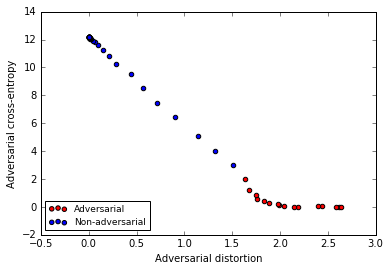

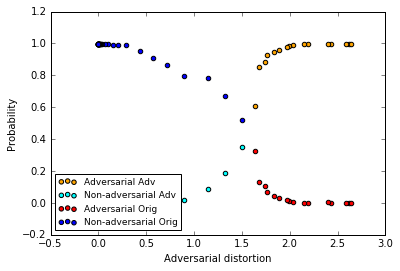

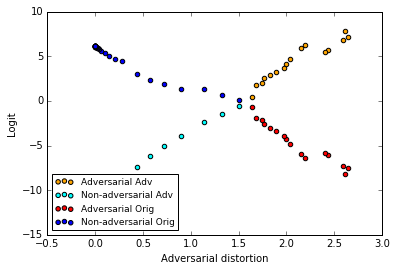

In [17]:
orig_adv_dist(plot = True)

Img 7521 Adv label 4


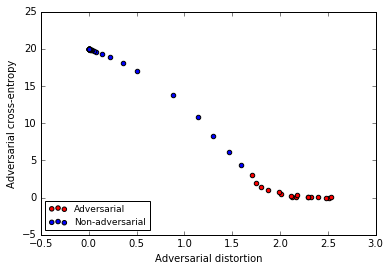

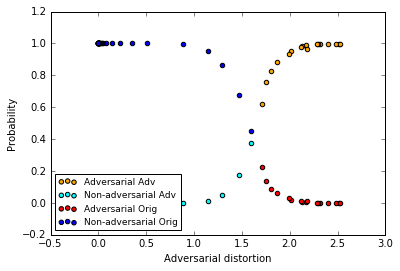

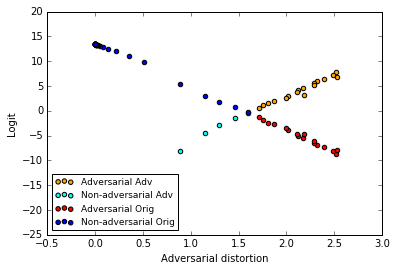

In [18]:
orig_adv_dist(plot = True)

Img 9060 Adv label 5


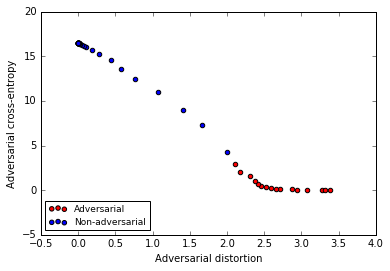

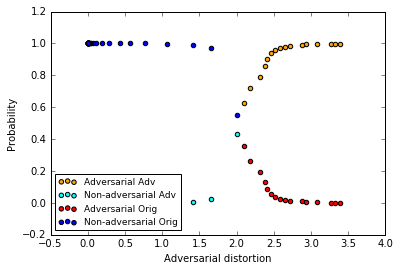

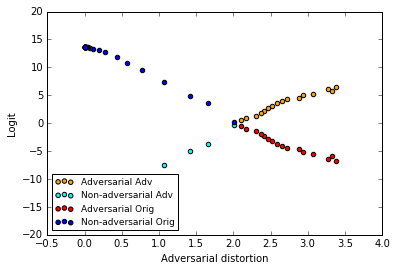

In [19]:
orig_adv_dist(plot = True)

Img 16679 Adv label 0


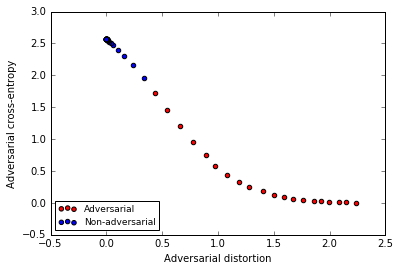

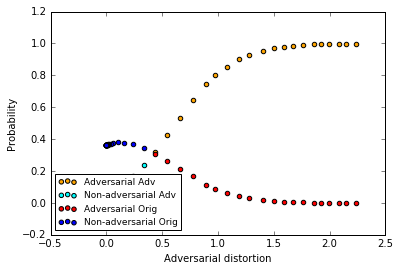

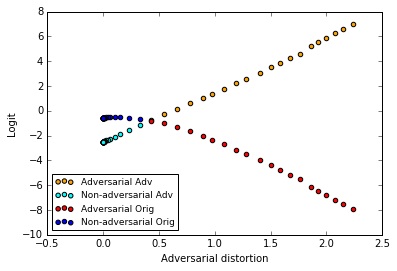

In [20]:
orig_adv_dist(plot = True)